In [4]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import sys
from collections import Counter
from sklearn.model_selection import KFold
import sklearn.metrics
import seaborn as sns
from scipy.interpolate import UnivariateSpline
sns.set(style='whitegrid')

In [5]:
from twitpol import config

In [6]:
#FiveThirtyEight polling dataset
df = pd.read_csv(config.DATA / 'ground_truth' / 'president_primary_polls.csv')
df.shape

(13880, 33)

In [4]:
# limit polls to top candidates and ignore irrelevant polling data
viable_candidates = ['Biden', 'Warren', 'Sanders', 'Harris', 'Buttigieg']
df_top4 = df[(df.party == 'DEM') & (df.answer.isin(viable_candidates)) &
             (df.stage == 'primary') & (df.notes != 'head-to-head poll')]

In [6]:
election_day = datetime(2018, 11, 5)
def convert_to_datetime(date):
    return (datetime.strptime(date, '%m/%d/%y') - election_day).days

start_day = np.array(df_top4.start_date.apply(convert_to_datetime))
end_day = np.array(df_top4.end_date.apply(convert_to_datetime))
df_top4.loc[:, 'average_date'] = np.round((start_day + end_day) / 2)

/Users/wfried/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
# last date polls go up to
latest_date = int(df_top4.average_date.max())

In [7]:
# look at polls starting March 1st
election_to_march1 = (datetime(2019, 2, 28) - election_day).days
df_national = df_top4[df_top4.state.isnull() & (df_top4.average_date > election_to_march1)]

In [8]:
# exclude polls that don't ask voters who their top choice is out of the entire field
exclusions = [('Monmouth University', 93516), ('Morning Consult', 94118), ('Change Research', 93731),
              ('Change Research', 94156), ('Monmouth University', 94198), ('ABC News/Washington Post', 94265),
              ('McLaughlin & Associates', 111865), ('Harris Insights & Analytics', 112558)]

df_national_filtered = df_national[df_national.average_date > election_to_march1]
print(df_national_filtered.shape)
for pollster, question_id in exclusions:
    df_national_filtered = df_national_filtered[(df_national_filtered.pollster != pollster)
                                                | (df_national_filtered.question_id != question_id)]

df_national_filtered.loc[df_national_filtered.pollster == 'Public Religion Research Institute', 'fte_grade'] = 'A-'

df_national_filtered = df_national_filtered[~df_national_filtered.fte_grade.isna()]
print(df_national_filtered.shape)

(1924, 34)
(1715, 34)


nonparametric regression approaches:

-scipy.interpolate.splev: doesn't support setting weights on data points

-scipy.interpolate.make_interp_spline: doesn't support setting weights on data points

-scipy cubic spline: horrible predictions

-Gaussian process: produces highly jagged predictions and doesn't support setting weights on data points

-LOESS: doesn't support setting weights on data points

-radius neighbors regressor: doesn't support setting weights on data points

-Nadaraya-Watson kernel regression: doesn't support setting weights on data points

-support vector regression: produces highly jagged predictions

-KernelRidge: horrible predictions

-Random forest: works but need to set depth of trees

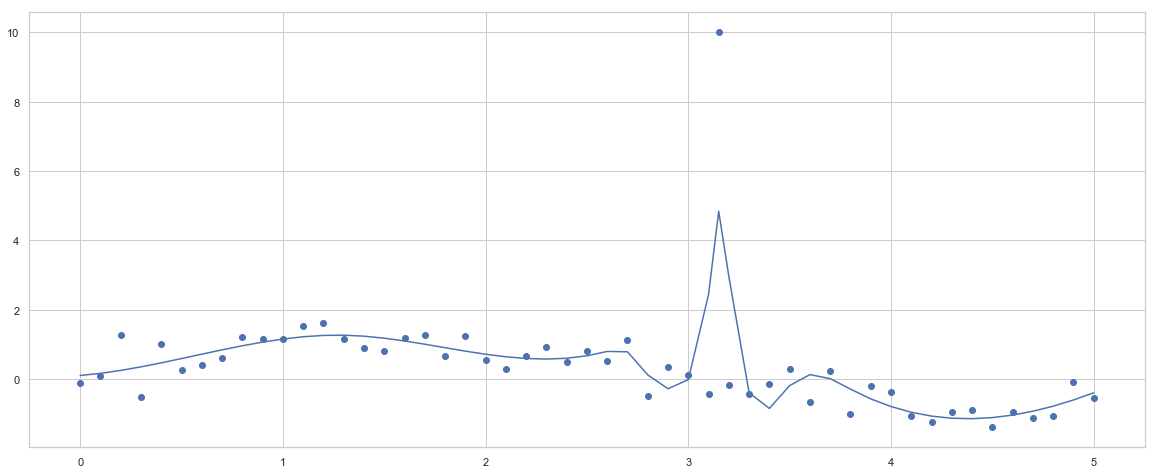

In [10]:
# issues with UnivariateSpline (very sensitive to outliers)
x = np.linspace(0, 5, 51)
y = np.sin(x) + np.random.normal(scale=0.4, size=len(x))

if False:
    extra_x = [2.2 + x / 1000 for x in range(1, 100)]
    extra_y = np.random.normal(scale=1, size=len(extra_x))
    x = np.append(x, extra_x)
    y = np.append(y, extra_y)

x = np.append(x, [3.15])
y = np.append(y, [10])


sort_idx = np.argsort(x)
x = x[sort_idx]
y = y[sort_idx]

spline = UnivariateSpline(x,y)
plt.figure(figsize=(20, 8))
plt.scatter(x,y)
plt.plot(x, spline(x))
plt.show()

In [15]:
# ignore polls that are ranked very low
df_national_filtered = df_national_filtered[~df_national_filtered.fte_grade.isin(['D-', 'C/D'])]
fte_grades = list(df_national_filtered.fte_grade)

# count of all grades
for grade in set(fte_grades):
    print('{}: count: {}'.format(grade, fte_grades.count(grade)))

A+: count: 75
B+: count: 65
A: count: 25
A/B: count: 75
B-: count: 250
C+: count: 765
B/C: count: 250
C: count: 55
B: count: 5
A-: count: 115


In [16]:
# map grade to numeric value
grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-']
grade2val = {grade: i for i, grade in enumerate(grades)}
grade2val['A/B'] = np.mean([1, 4])
grade2val['B/C'] = np.mean([4, 7])

In [17]:
# smooth polling predictions by calculating a running average of +/- window
def smooth_predictions(pred, window):
    return [np.mean(pred[max(0, idx - window): min(idx + window + 1, len(pred) - 1)]) 
                    for idx in range(len(pred))]

In [18]:
# cross validated MSE given model, predictors, response variable and weight associated with each observation
def cross_val_scores_weighted(model, X, y, weights, cv=5, metric=sklearn.metrics.mean_squared_error):
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        model_clone = sklearn.base.clone(model)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        weights_train, weights_test = weights[train_index], weights[test_index]
        model_clone.fit(X_train, y_train, sample_weight=weights_train)
        y_pred = model_clone.predict(X_test)
        score = metric(y_test, y_pred, sample_weight = weights_test)
        scores.append(score)
    return scores

In [58]:
# grid search to determine optimal values of alpha and lambda
def execute_grid_search():
    lambdas = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3]
    depths = [i for i in range(1, 6)]
    alphas = np.linspace(0, 1, 11)

    cv_df = pd.DataFrame(index=['alpha=' + str(alpha) for alpha in alphas], 
                         columns=['lambda=' + str(lambda_) for lambda_ in lambdas])

    for lambda_ in lambdas:
        costs_lst = []
        for alpha in alphas:
            cost = 0
            for candidate in viable_candidates:
                df_cand = df_national_filtered[df_national_filtered.answer == candidate]
                average_date = np.array(df_cand.average_date)
                pcts = np.array(df_cand.pct)
                sample_sizes = np.sqrt(np.array(df_cand.sample_size))
                grades = np.array([grade2val[grade] for grade in list(df_cand.fte_grade)])
                weights = alpha * np.exp(-lambda_ * grades) + (1 - alpha) * sample_sizes

                cv_avg_scores = []
                for depth in depths:
                    rf_model = RandomForestRegressor(n_estimators=100, max_depth=depth)
                    cv_depth_scores = cross_val_scores_weighted(rf_model, average_date.reshape(-1, 1), pcts, weights) 
                    cv_avg_scores.append(np.mean(cv_depth_scores))

                best_rf_model = RandomForestRegressor(n_estimators=100, max_depth=depths[np.argmin(cv_avg_scores)])

                cv_weights_scores = cross_val_scores_weighted(best_rf_model, average_date.reshape(-1, 1), pcts, weights) 
                cost += np.mean(cv_weights_scores)

            costs_lst.append(cost / len(viable_candidates))

        cv_df['lambda=' + str(lambda_)] = costs_lst 
        
    return cv_df

In [48]:
cv_df = execute_grid_search()
cv_df.to_csv('cv_results.csv')

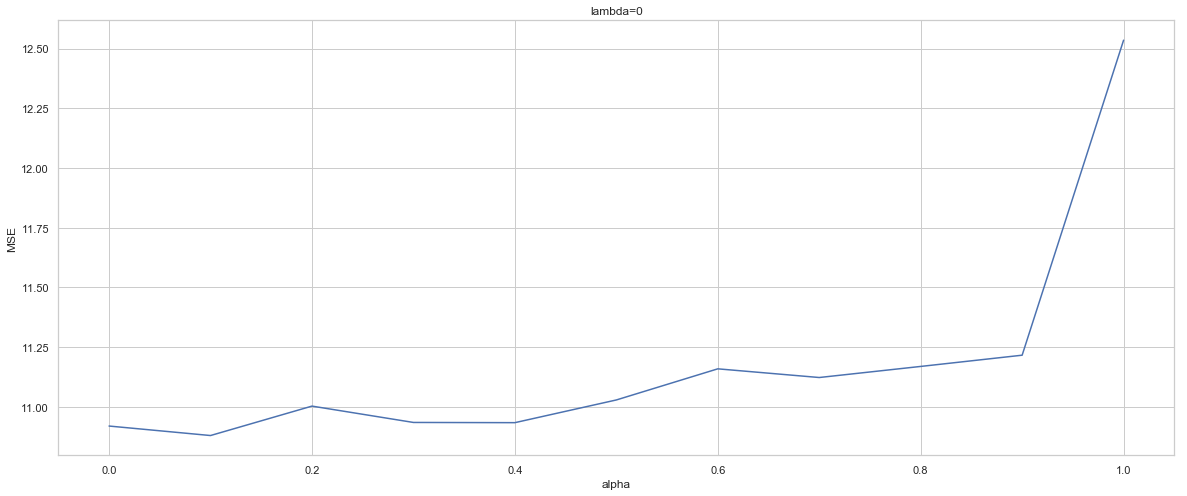

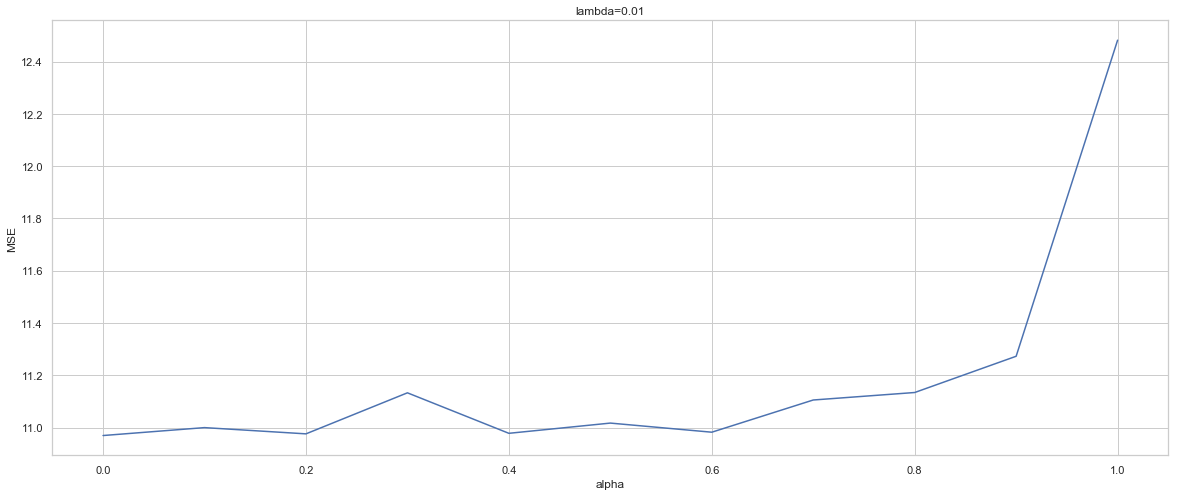

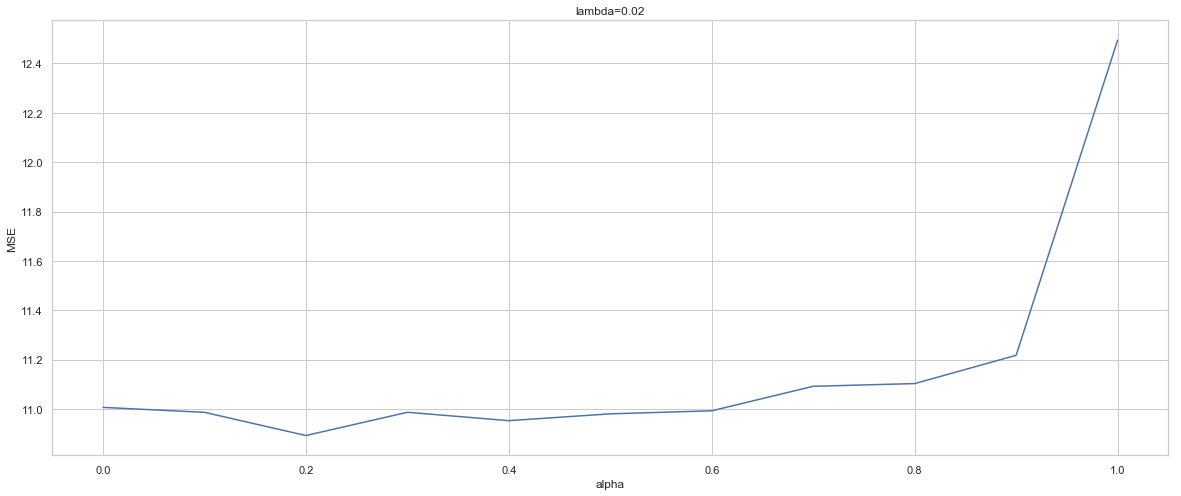

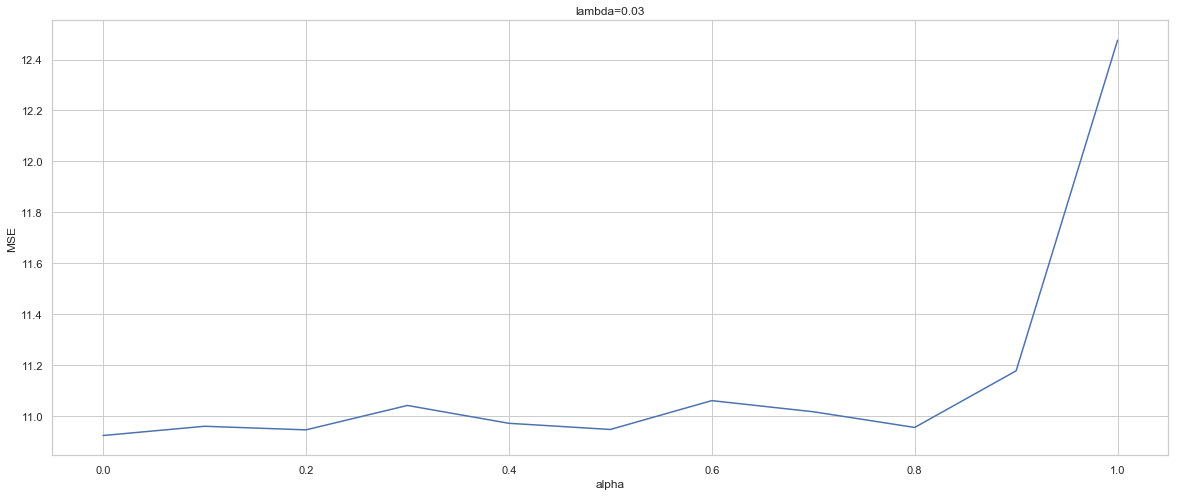

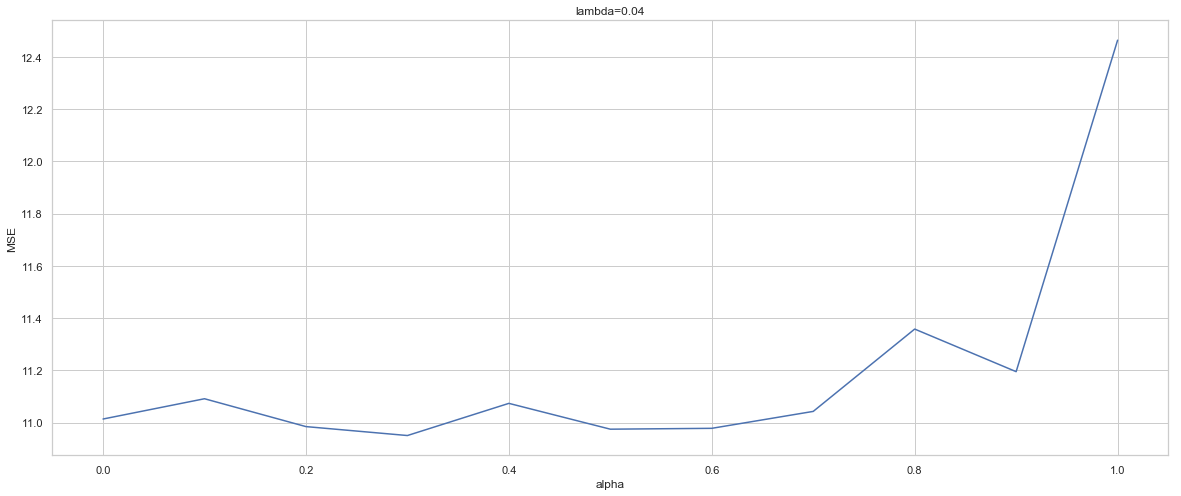

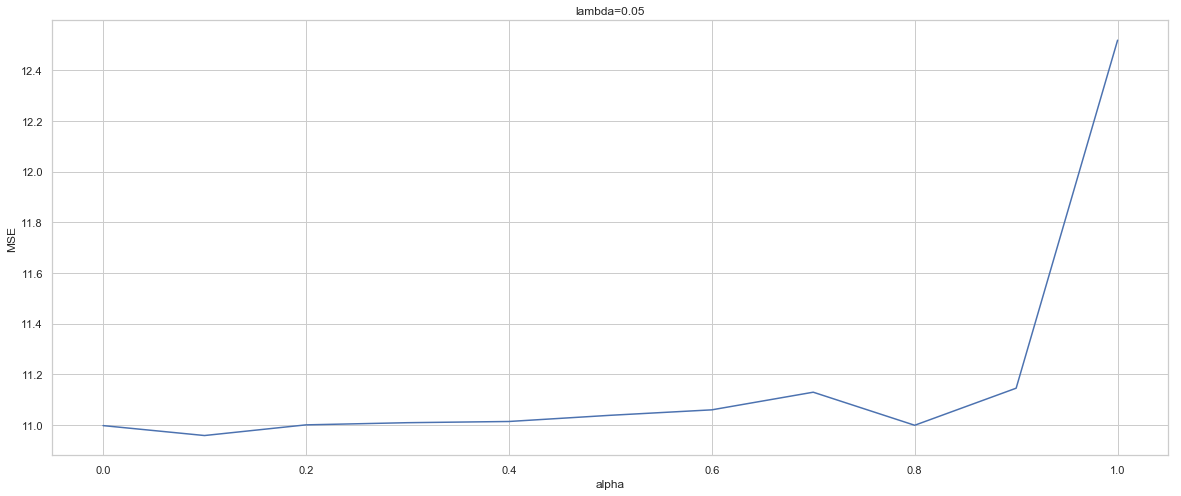

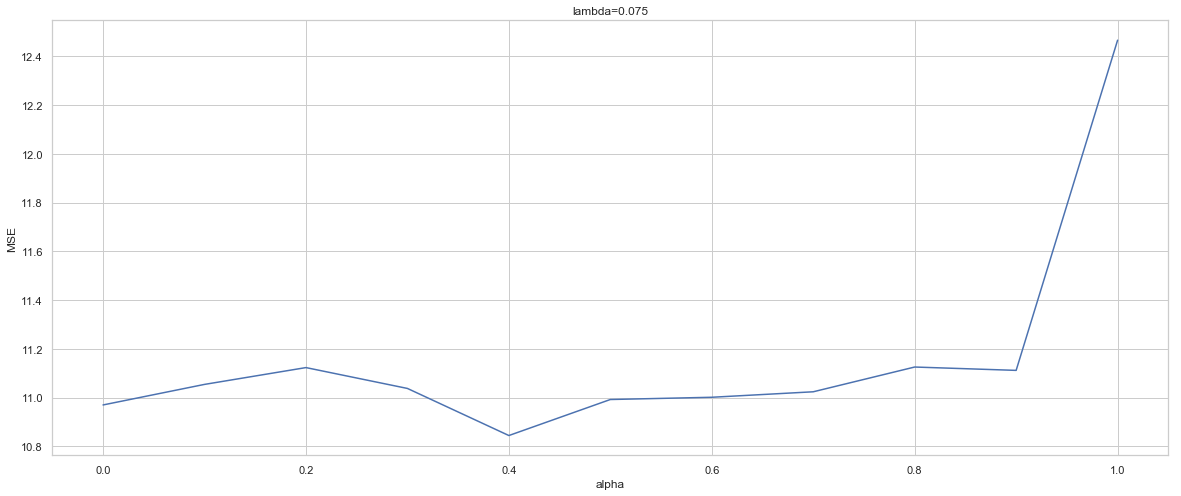

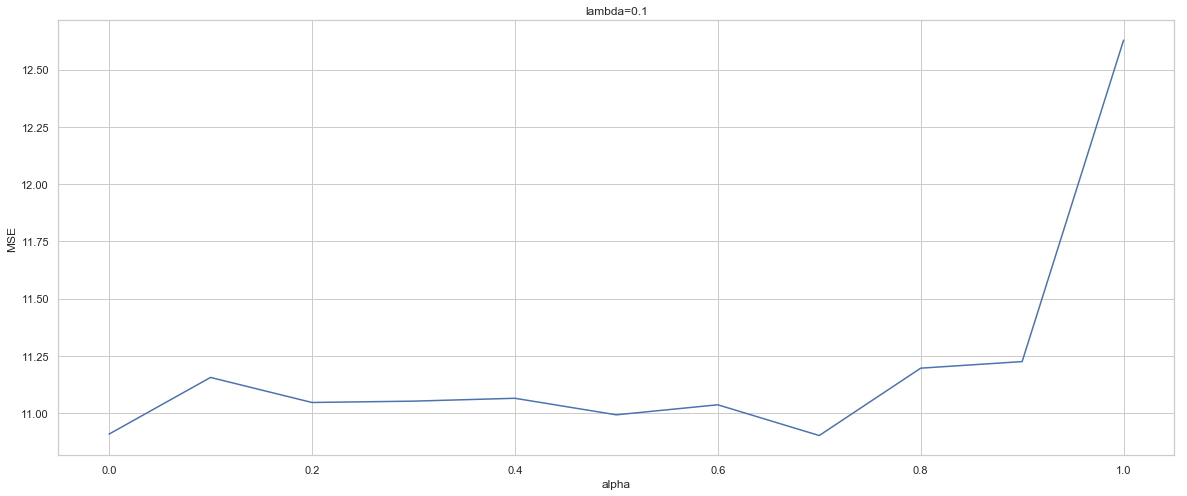

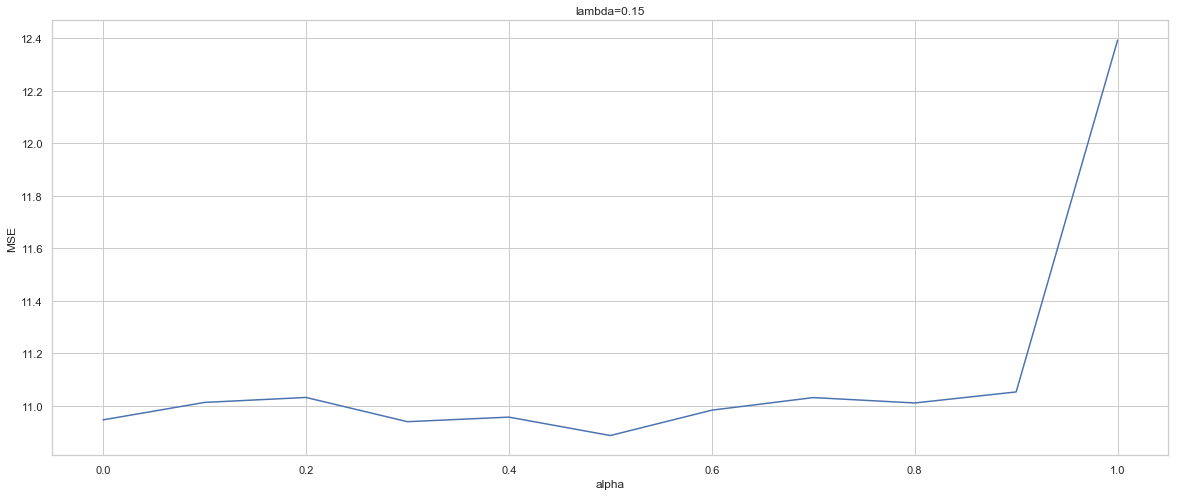

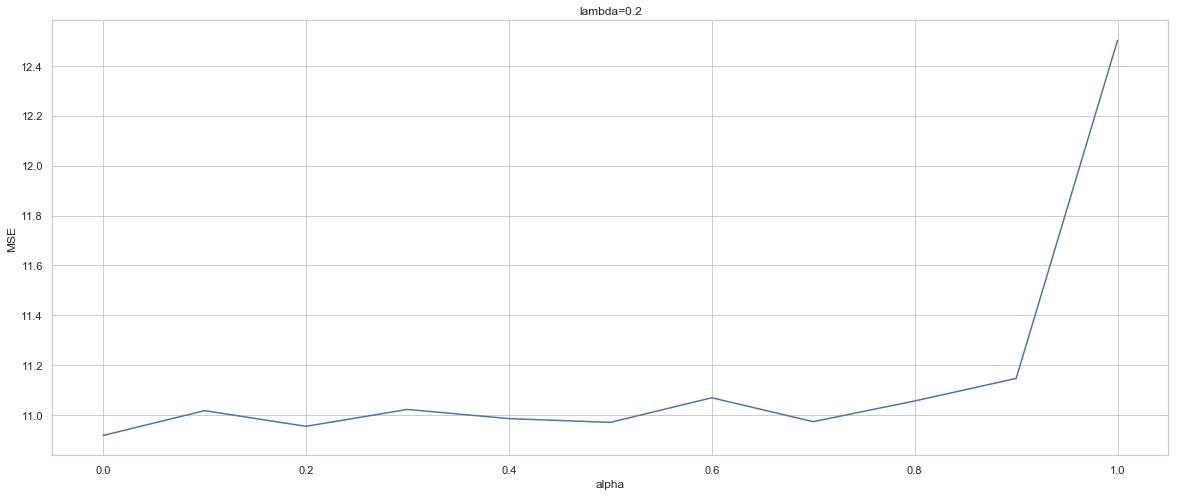

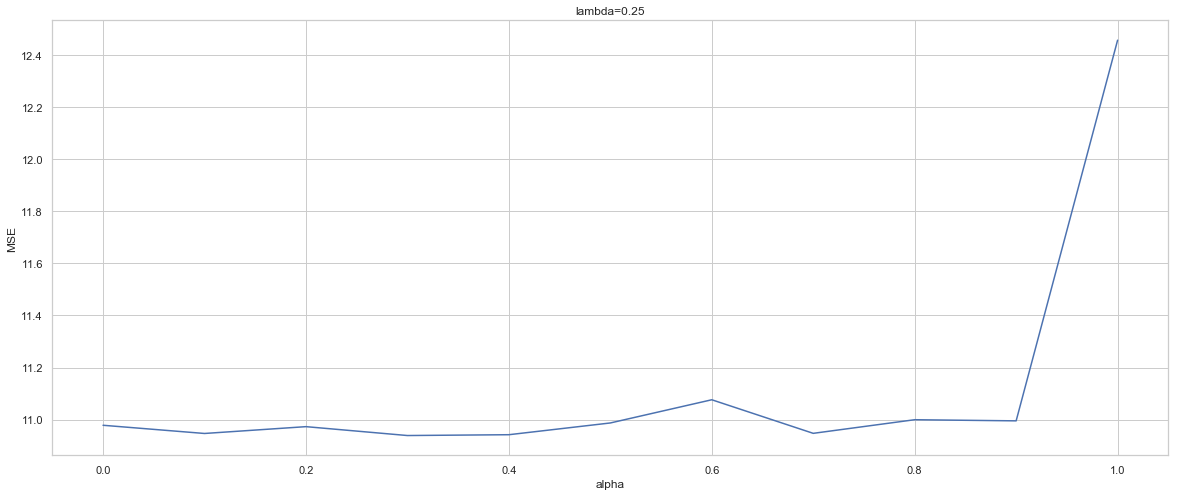

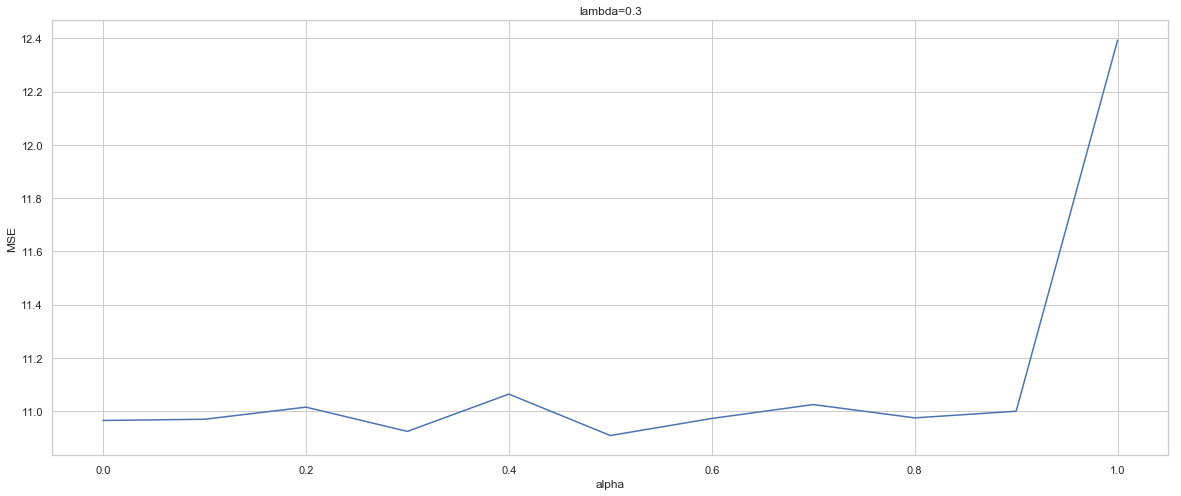

In [106]:
# select optimal hyperparameters from dataframe
cv_df_stored = pd.read_csv(config.DATA / 'ground_truth' / 'cv_results.csv', index_col=0)
cv_df_stored.index = [x / 10 for x in range(11)]
min_mse = np.Inf
for column in cv_df_stored.columns:
    
    lowest_mse = min(cv_df_stored[column])
    if lowest_mse < min_mse:
        min_mse = lowest_mse
        best_lambda = float(column.split('=')[-1])
        best_alpha = np.argmin(np.array(cv_df_stored[column]))
    
    plt.figure(figsize=(20, 8))
    plt.plot(cv_df_stored.index, cv_df_stored[column])
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.title(column)
    plt.show()

In [104]:
best_lambda

0.075

In [60]:
depths = [i for i in range(1, 6)]

In [101]:
# estimate ground truth polling for each candidate
def obtain_predictions(days_since_election, graphics=False, entire_period=False):
    candidate2predictions = {}
    for candidate in viable_candidates:
        df_cand = df_national_filtered[(df_national_filtered.answer == candidate) & 
                                       (df_national_filtered.average_date < days_since_election)]

        average_date = np.array(df_cand.average_date)
        pcts = np.array(df_cand.pct)
        sample_sizes = np.sqrt(np.array(df_cand.sample_size))
        grades = np.array([grade2val[grade] for grade in list(df_cand.fte_grade)])
        weights = best_alpha * np.exp(-best_lambda * grades) + (1 - best_alpha) * sample_sizes

        cv_avg_scores = []
        for depth in depths:
            rf_model = RandomForestRegressor(n_estimators=100, max_depth=depth)
            cv_depth_scores = cross_val_scores_weighted(rf_model, average_date.reshape(-1, 1), pcts, weights) 
            cv_avg_scores.append(np.mean(cv_depth_scores))

        best_rf_model = RandomForestRegressor(n_estimators=100, max_depth=depths[np.argmin(cv_avg_scores)]).fit(
                                              average_date.reshape(-1, 1), pcts, sample_weight=weights)

        days = np.linspace(int(min(average_date)), days_since_election, 
                            days_since_election - int(min(average_date)) + 1, dtype=int)

        rf_pred = best_rf_model.predict(days.reshape(-1, 1))
        smooth_pred = smooth_predictions(rf_pred, 3)
        
        if graphics:
            plt.figure(figsize=(20, 8))
            max_weight = max(weights)

            for i in range(len(average_date)):
                plt.scatter(average_date[i], pcts[i], color='b', alpha= weights[i] / max_weight)

            plt.plot(days, smooth_pred, color='r')
            
            locs = [150 + 50 * x for x in range(5)]
            dates = [(election_day + timedelta(days=day)).date() for day in locs]
            
            plt.xticks(locs, dates, rotation=25, fontsize=15)
            plt.xlabel('date', fontsize=15)
            plt.ylabel('% support', fontsize=15)
            plt.title(candidate, fontsize=20)
            plt.savefig(candidate + '_polls.png')
            plt.show() 
        
        days = [election_day + timedelta(days=int(day)) for day in days]
        candidate2predictions[candidate] = dict(zip(days, smooth_pred)) if entire_period else smooth_pred[-1]
        
    return candidate2predictions
    

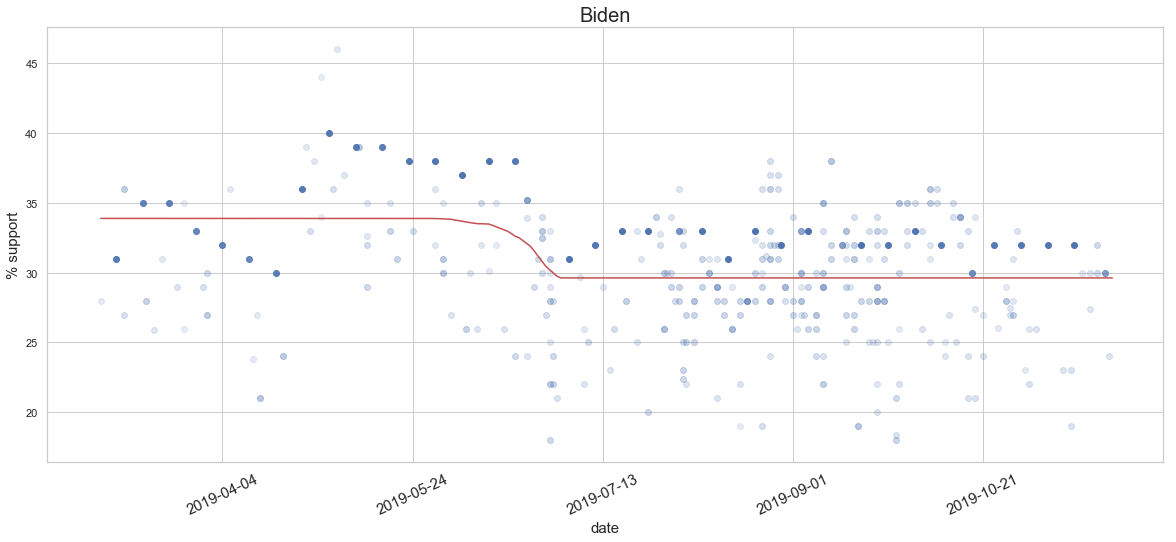

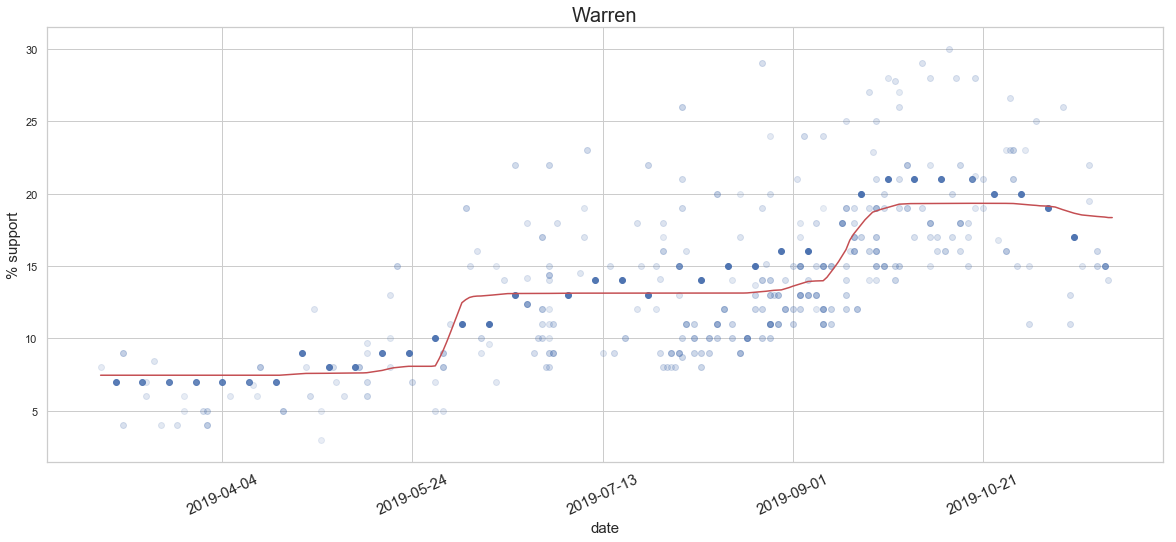

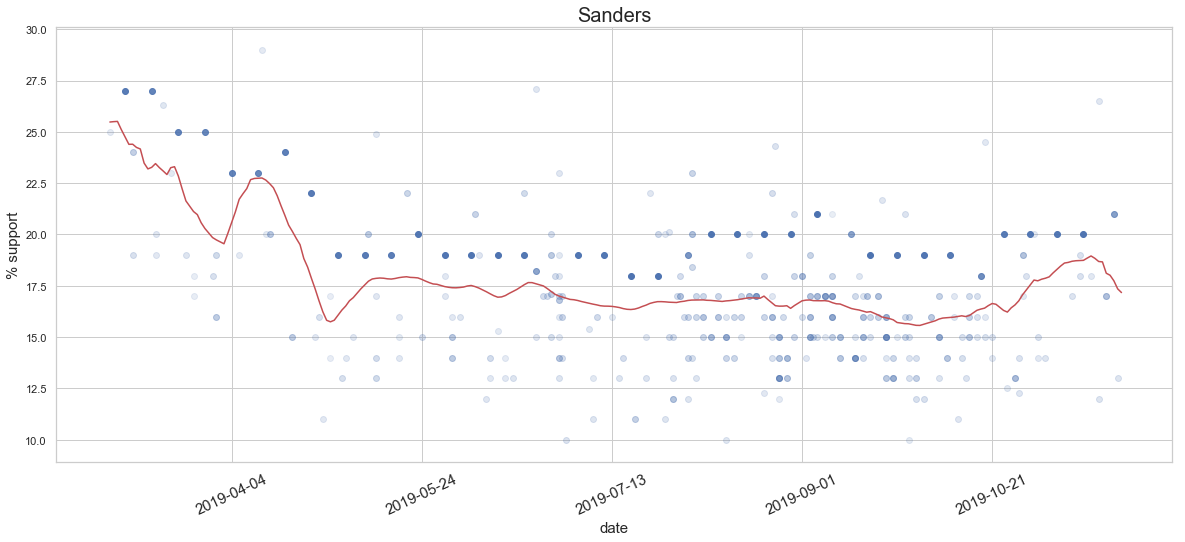

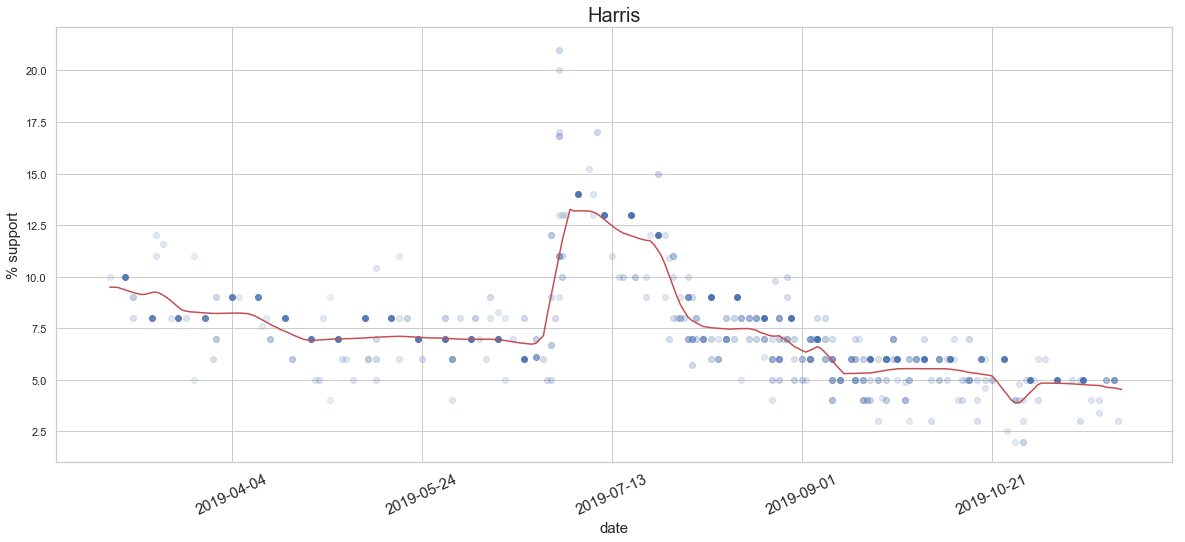

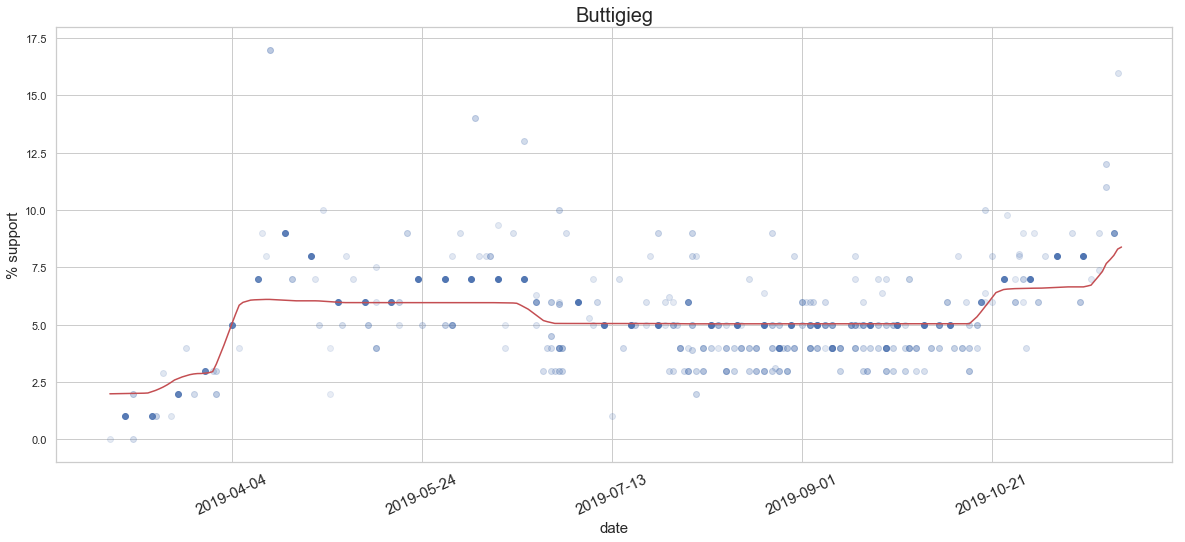

In [102]:
candidate2predictions = obtain_predictions(latest_date, graphics=True, entire_period=True) 

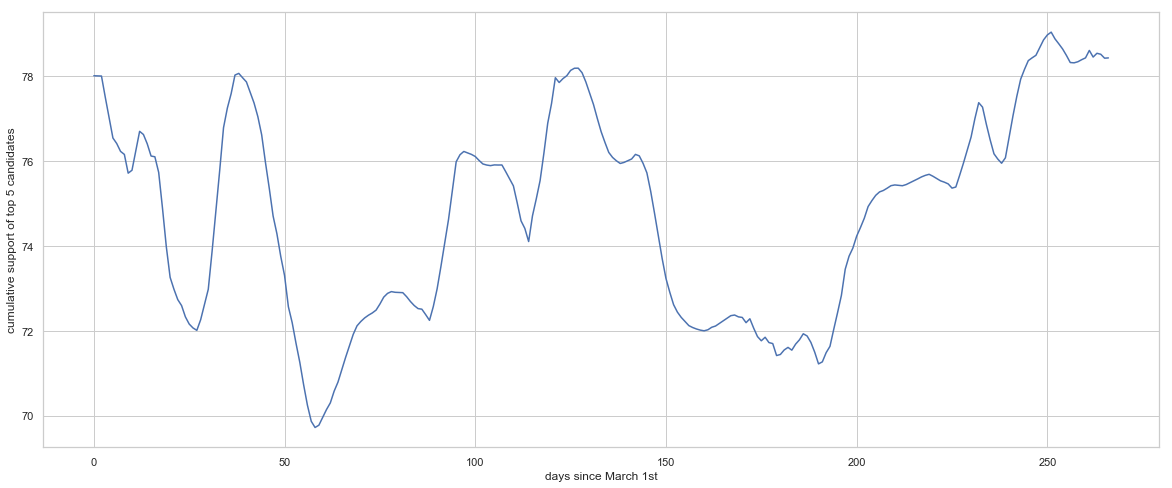

In [63]:
# calculate cumulative support of five candidates as a function of time
cnt = np.zeros(len(candidate2predictions['Warren']))
for candidate in viable_candidates:
    cnt += np.array(list(candidate2predictions[candidate].values()))

plt.figure(figsize=(20, 8))   
plt.plot(cnt)
plt.xlabel('days since March 1st')
plt.ylabel('cumulative support of top 5 candidates')
plt.show()

In [64]:
# write estimate ground truth to csv file
ground_truth_polling_df = pd.DataFrame.from_dict(candidate2predictions)
ground_truth_polling_df.to_csv('ground_truth_polling.csv')

In [65]:
# estimate ground truth at time t using all polls up until time t
first_date_prediction = 130
best_guess_polling_df = pd.DataFrame(columns=viable_candidates)
days_lst = [x for x in range(first_date_prediction, latest_date + 1)]
for day in days_lst:
    preds = list(obtain_predictions(day).values())
    best_guess_polling_df.loc[day] = preds

In [66]:
# write estimated ground truth to csv file
best_guess_polling_df.index = [election_day + timedelta(days=int(day)) for day in best_guess_polling_df.index]
best_guess_polling_df.to_csv('best_guess_polling.csv')